In [1]:
%cd /content/drive/MyDrive/1) Model

/content/drive/MyDrive/1) Model


In [2]:
import os
import tensorflow as tf
import h5py
import numpy as np
from sklearn.metrics import accuracy_score

One-Hot Encoding

In [3]:
import numpy as np

# Path to your .npz file
data_file = "x1.npz"

with np.load(data_file) as data:
  # Access arrays by their names in the archive
  x1 = data["x1"]

data_file = "y1.npz"

with np.load(data_file) as data:
  # Access arrays by their names in the archive
  y1 = data["y1"]

In [4]:
x1.shape

(287971, 1024, 2)

Post Training Quantization FLOAT 16

In [5]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [6]:
base_model = "2case.h5"
model = tf.keras.models.load_model(base_model)

In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

In [8]:
tflite_model = converter.convert()

In [9]:
open("own_FLOAT16.tflite","wb").write(tflite_model)

16794932

In [10]:
convert_bytes(get_file_size(base_model), "KB")

File size: 98424.414 Kilobytes


In [11]:
TF_LITE_MODEL_FILE_NAME = "own_FLOAT16.tflite"

In [12]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

File size: 16401.301 Kilobytes


Check Input Tensor Shape

In [13]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [   1 1024    2    1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 2]
Output Type: <class 'numpy.float32'>


In [14]:
interpreter.resize_tensor_input(input_details[0]['index'], (5000, 1024, 2, 1))
interpreter.resize_tensor_input(output_details[0]['index'], (5000, 16))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [5000 1024    2    1]
Input Type: <class 'numpy.float32'>
Output Shape: [5000    2]
Output Type: <class 'numpy.float32'>


In [15]:
X_test_reshaped = x1[0:5000].reshape(5000, 1024, 2, 1)

In [16]:
interpreter.set_tensor(input_details[0]['index'], X_test_reshaped)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (5000, 2)


In [19]:
prediction_classes

array([1, 1, 1, ..., 0, 0, 0])

Base model accuracy

In [ ]:
model.evaluate(x1, y1, verbose=1)

Post Training Float 16 accuracy

In [17]:
acc = accuracy_score(prediction_classes, y1[0:5000])

In [18]:
print('Test accuracy TFLITE model :', acc)

Test accuracy TFLITE model : 0.999


Access Quantized Weights of TFLite

In [ ]:
interpreter.get_tensor_details()

[{'name': 'serving_default_conv2d_input:0',
  'index': 0,
  'shape': array([31997,   128,     2,     1], dtype=int32),
  'shape_signature': array([ -1, 128,   2,   1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'sequential/flatten/Const',
  'index': 1,
  'shape': array([2], dtype=int32),
  'shape_signature': array([2], dtype=int32),
  'dtype': numpy.int32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'sequential/conv2d/BiasAdd/ReadVariableOp',
  'index': 2,
  'shape': array([32], dtype=int32),
  'shape_signature': array([32], dtype=int32),
  'dtype': numpy.float16,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scale

In [ ]:
test_dset = h5py.File("sdr_wifi_test.hdf5", 'r')
X_test = dset['X'][()]
y_test = dset['y'][()]

In [ ]:
B = y_test

test_matches0 = np.where(np.all(B == [0, 0, 0, 0], axis=1))[0]
test_matches1 = np.where(np.all(B == [0, 0, 0, 1], axis=1))[0]
test_matches2 = np.where(np.all(B == [0, 0, 1, 0], axis=1))[0]
test_matches3 = np.where(np.all(B == [0, 0, 1, 1], axis=1))[0]
test_matches4 = np.where(np.all(B == [0, 1, 0, 0], axis=1))[0]
test_matches5 = np.where(np.all(B == [0, 1, 0, 1], axis=1))[0]
test_matches6 = np.where(np.all(B == [0, 1, 1, 0], axis=1))[0]
test_matches7 = np.where(np.all(B == [0, 1, 1, 1], axis=1))[0]
test_matches8 = np.where(np.all(B == [1, 0, 0, 0], axis=1))[0]
test_matches9 = np.where(np.all(B == [1, 0, 0, 1], axis=1))[0]
test_matches10 = np.where(np.all(B == [1, 0, 1, 0], axis=1))[0]
test_matches11 = np.where(np.all(B == [1, 0, 1, 1], axis=1))[0]
test_matches12 = np.where(np.all(B == [1, 1, 0, 0], axis=1))[0]
test_matches13 = np.where(np.all(B == [1, 1, 0, 1], axis=1))[0]
test_matches14 = np.where(np.all(B == [1, 1, 1, 0], axis=1))[0]
test_matches15 = np.where(np.all(B == [1, 1, 1, 1], axis=1))[0]

test_list = list(B)


value_to_replace = 0
for index in test_matches0:
    test_list[index] = value_to_replace
value_to_replace = 1
for index in test_matches1:
    test_list[index] = value_to_replace
value_to_replace = 2
for index in test_matches2:
    test_list[index] = value_to_replace
value_to_replace = 3
for index in test_matches3:
    test_list[index] = value_to_replace
value_to_replace = 4
for index in test_matches4:
    test_list[index] = value_to_replace
value_to_replace = 5
for index in test_matches5:
    test_list[index] = value_to_replace
value_to_replace = 6
for index in test_matches6:
    test_list[index] = value_to_replace
value_to_replace = 7
for index in test_matches7:
    test_list[index] = value_to_replace
value_to_replace = 8
for index in test_matches8:
    test_list[index] = value_to_replace
value_to_replace = 9
for index in test_matches9:
    test_list[index] = value_to_replace
value_to_replace = 10
for index in test_matches10:
    test_list[index] = value_to_replace
value_to_replace = 11
for index in test_matches11:
    test_list[index] = value_to_replace
value_to_replace = 12
for index in test_matches12:
    test_list[index] = value_to_replace
value_to_replace = 13
for index in test_matches13:
    test_list[index] = value_to_replace
value_to_replace = 14
for index in test_matches14:
    test_list[index] = value_to_replace
value_to_replace = 15
for index in test_matches15:
    test_list[index] = value_to_replace

test_label = np.array(test_list)

In [ ]:
y_pred = model.predict(X_test)

9000/9000 [==============================] - 86s 10ms/step


In [ ]:
y_pred

array([[9.7438515e-06, 6.1954124e-06, 8.1883145e-10, ..., 2.9689226e-02,
        5.4487973e-06, 8.9901391e-08],
       [4.9851395e-05, 1.2083226e-06, 9.9746400e-01, ..., 4.3234764e-14,
        1.7609750e-08, 8.8016660e-12],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [1.3316447e-08, 3.5584122e-10, 4.8920712e-03, ..., 1.2958783e-13,
        1.7399025e-04, 2.3238753e-09],
       [0.0000000e+00, 6.7614501e-27, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0275707e-25],
       [4.8008800e-04, 8.0679411e-07, 1.0876417e-03, ..., 4.0837490e-06,
        8.5520645e-05, 5.8435359e-09]], dtype=float32)

In [ ]:
predicted_classes = np.argmax(y_pred, axis=1)
y_predicted = np.array(predicted_classes)
y_predicted

array([9, 2, 8, ..., 6, 7, 6])

In [ ]:
test_label

array([9, 2, 8, ..., 6, 7, 6])

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_label, y_predicted)

In [ ]:
print(confusion_matrix)

[[18016    23     0     0     5     0     0     0     0     1     2     0
      0     0     1     0]
 [ 1942 16032     0     1     0     2     0     1     0     5     0     1
      0     0     0     0]
 [    4    10 17987     1     1     0    19     0     0     1     1     0
      0     0     0    32]
 [    3    14   773 17165     3     0     0     1     0     2     1     3
      0     0     0     1]
 [   35     0     0     0 17882    49     0     0     0     1     2     0
      0     0     1     0]
 [    7     1     0     0    91 17897     1     0     0     0     0     4
      0     0     0     0]
 [   16     0    40     7    17     2 17897    25     0     0     1     0
      2     0     5     0]
 [    0     0    63     4     4    17    71 17821     0     0     0     0
      0     0     0     2]
 [   21     0     0     4     5     0     0     0 17903     7     3     2
     41     2     1     3]
 [   32     6    10     0     8    59     0     0  1007 16868     1     2
      1     0    

ValueError: The number of FixedLocator locations (16), usually from a call to set_ticks, does not match the number of labels (2).

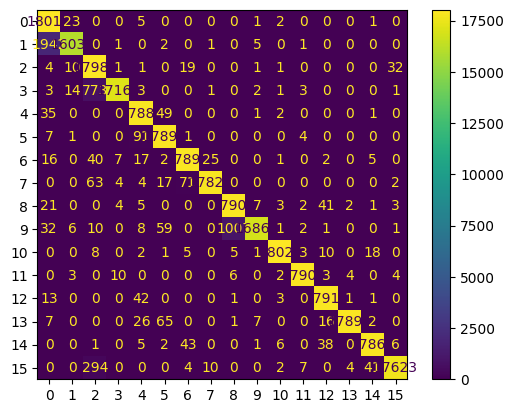

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(test_label, y_predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()